Кирилл Лалаянц, R33352

# Лабораторная работа No1 
## Формы представления линейных систем

Импорт необходимых для работы библиотек. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import control 
import sympy

sympy.init_printing()
p = sympy.Symbol("s")

Ввод данных варианта.

In [2]:
var_num = 6

# Task 1 & 2
a2, a1, a0, b2, b1, b0 = [9, 3, 6, 12, 7, 7]

# Task 3
A11 = p + 19
A12 = p + 3
A21 = p + 6
A22 = p + 2
task3_A = sympy.Matrix([[A11, A12], [A21, A22]])

B11 = 7
B12 = 7
B21 = 5
B22 = 6
task3_B = sympy.Matrix([[B11, B12], [B21, B22]])

# Task 4
task4_A = np.array([[0, -9], [1, -6]])
task4_B = np.array([[1], [5]])
task4_C = np.array([2, 5])

# Task 5
task5_A = np.array([[0, -9], [1, -6]])
task5_B = np.array([[1, 4], [3, 5]])
task5_C = np.array([[2, 7], [4, 6]])

Параметры шага времени симуляции

In [3]:
dt = 0.001  # шаг симуляции
max_t = 50  # время симуляции
ts = np.linspace(0, max_t, int(max_t / dt))
SAVE_PATH = 'tex-report/figs/'

### Задание 1. Одноканальная система в форме вход-выход.

In [4]:
# Создание TF
den = [1, a2, a1, a0]  # denominator
num = [b2, b1, b0]  # numerator
transferFunction = control.tf(num, den)

# Моделирование с 0 начальными значениями
transferFunction_y = control.forced_response(transferFunction, U=1, X0=0, T=ts).outputs

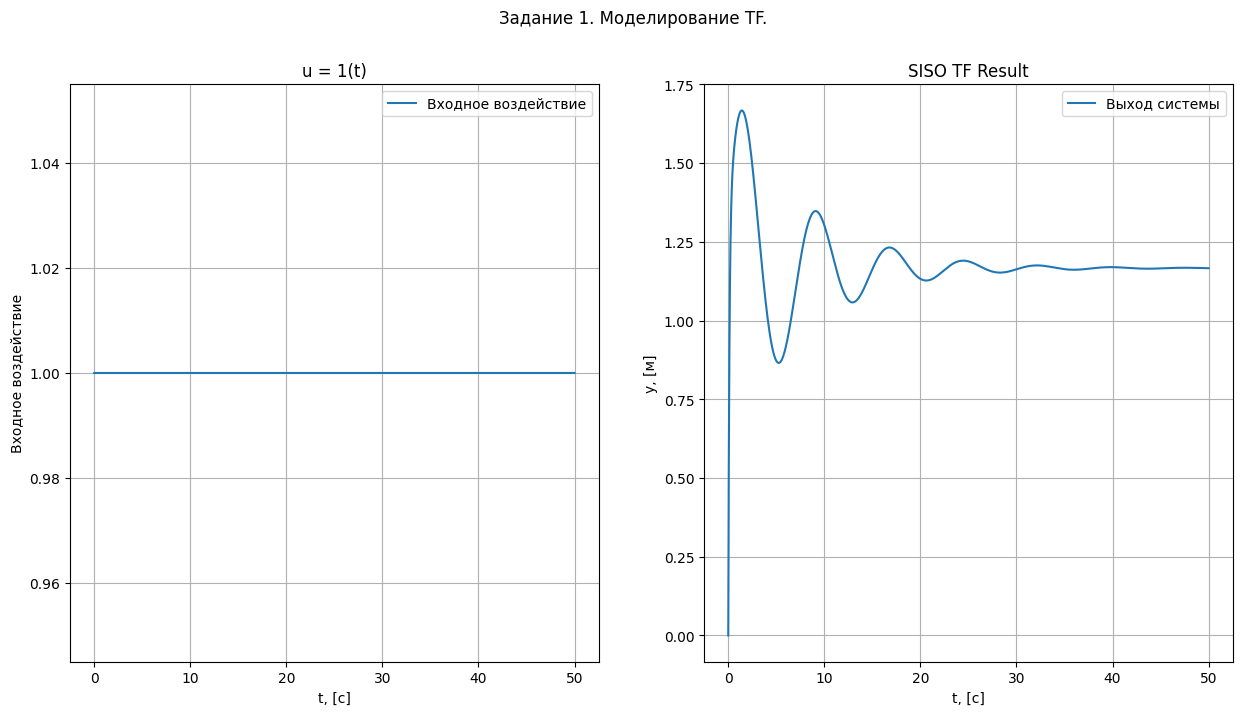

In [5]:
# Построение графиков
fig, axs = plt.subplots(1, 2, figsize=(15, 7.5))
fig.suptitle("Задание 1. Моделирование TF.")

axs[0].plot(ts, [1] * len(ts), label='Входное воздействие')
axs[0].set_title(f"u = 1(t)")
axs[0].set_xlabel(f"t, [c]")
axs[0].set_ylabel(f"Входное воздействие")
axs[0].grid(True)
axs[0].legend()

axs[1].plot(ts, transferFunction_y, label='Выход системы')
axs[1].set_title(f"SISO TF Result")
axs[1].set_xlabel(f"t, [c]")
axs[1].set_ylabel(f"y, [м]")
axs[1].grid(True)
axs[1].legend()

plt.savefig(f'{SAVE_PATH}/task1.jpg')

### Задание 2. Переход от формы вход-выход к форме вход-состояние-выход.


In [6]:
# Перевод передаточной функции в систему В-С-В
state = control.tf2ss(transferFunction)

# Приведение к нужной форме
canonical_reachable_form = control.canonical_form(state, form="reachable")
canonical_observable_form = control.canonical_form(state, form="observable")
canonical_modal_form = control.canonical_form(state, form="modal")

if var_num % 2 == 0:
    desired_form = canonical_reachable_form[0]
    print(f"Каноническая управляемая форма:")
else:
    desired_form = canonical_observable_form[0]
    print(f"Каноническая наблюдаемая форма:")
print(desired_form)

Каноническая управляемая форма:
A = [[-9. -3. -6.]
     [ 1.  0.  0.]
     [ 0.  1.  0.]]

B = [[1.]
     [0.]
     [0.]]

C = [[12.  7.  7.]]

D = [[0.]]



In [7]:
# Задание начальных условий для ручного моделирования
initial_state = np.array([[0, 0, 0]], dtype=np.float64).T
stateSpaceManual_y = []

# Ручное моделирование
for t in ts:
    initial_state += (desired_form.A @ initial_state + desired_form.B * 1) * dt
    stateSpaceManual_y.append(desired_form.C @ initial_state)

# Авто-моделирование
stateSpaceAuto_y = control.forced_response(desired_form, U=1, X0=0, T=ts).outputs

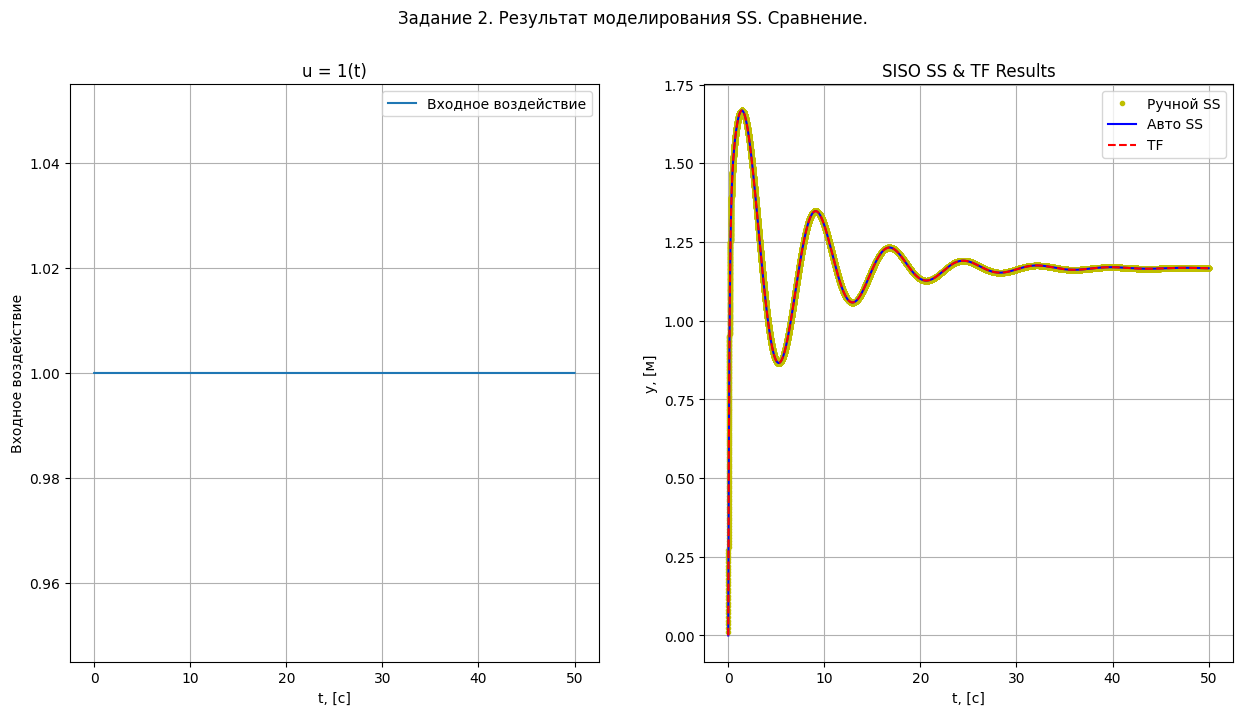

In [8]:
# Построение графиков
fig, axs = plt.subplots(1, 2, figsize=(15, 7.5))
fig.suptitle("Задание 2. Результат моделирования SS. Сравнение.")

axs[0].plot(ts, [1] * len(ts), label='Входное воздействие')
axs[0].set_title(f"u = 1(t)")
axs[0].set_xlabel(f"t, [c]")
axs[0].set_ylabel(f"Входное воздействие")
axs[0].grid(True)
axs[0].legend()
# axs[1].plot(ts, transferFunction_y)
axs[1].plot(ts, np.asarray(stateSpaceManual_y).reshape(-1), "y.", label="Ручной SS")
axs[1].plot(ts, stateSpaceAuto_y, "b", label="Авто SS")
axs[1].plot(ts, transferFunction_y, "r--", label="TF")
axs[1].set_title(f"SISO SS & TF Results")
axs[1].set_xlabel(f"t, [c]")
axs[1].set_ylabel(f"y, [м]")
axs[1].grid(True)
axs[1].legend()

plt.savefig(f'{SAVE_PATH}/task2.jpg')

### Задание 3. Многоканальная система в форме вход-выход.

Преобразование матриц в передаточную функцию.

In [32]:
# Взятие обратной матрицы
task3_A_inv = task3_A.inv()
# Перемножение матриц
Transform = task3_A_inv @ task3_B
# Упрощение
Transform.simplify()

nums = []
denums = []
# Парсинг числителей и знаменателей элементов матрицы
for element in Transform:
    num, denum = sympy.fraction(element)
    nums.append(sympy.Poly(num, p).coeffs())
    denums.append(sympy.Poly(denum, p).coeffs())
nums = np.array(nums, dtype=float).reshape((2, 2, 2))
denums = np.array(denums, dtype=float).reshape((2, 2, 2))

# Создание передаточной функции
mimo_TF = control.tf(nums, denums)
print(f"Получившаяся TF-матрица: ")
mimo_TF

Получившаяся TF-матрица: 


TransferFunction([[array([ 2., -1.]), array([ 1., -4.])], [array([-2., 53.]), array([-1., 72.])]], [[array([12., 20.]), array([12., 20.])], [array([12., 20.]), array([12., 20.])]])

In [36]:
print(mimo_TF)


Input 1 to output 1:
 2 s - 1
---------
12 s + 20

Input 1 to output 2:
-2 s + 53
---------
12 s + 20

Input 2 to output 1:
  s - 4
---------
12 s + 20

Input 2 to output 2:
 -s + 72
---------
12 s + 20



In [33]:
mimo_State = control.tf2ss(mimo_TF)
print('Представление в виде SS:')
mimo_State

Представление в виде SS:


StateSpace(array([[-1.66666667]]), array([[-0.60745011, -0.79435783]]), array([[ 0.5944704 ],
       [-7.72811526]]), array([[ 0.16666667,  0.08333333],
       [-0.16666667, -0.08333333]]))

In [17]:
# Входы от времени
u1 = np.zeros_like(ts) + 1
u2 = 2 * np.sin(ts)
mimo_Us = np.array([u1, u2])

# Симуляция
mimo_TF_y = control.forced_response(
    mimo_TF, U=mimo_Us, X0=0, T=ts
).outputs

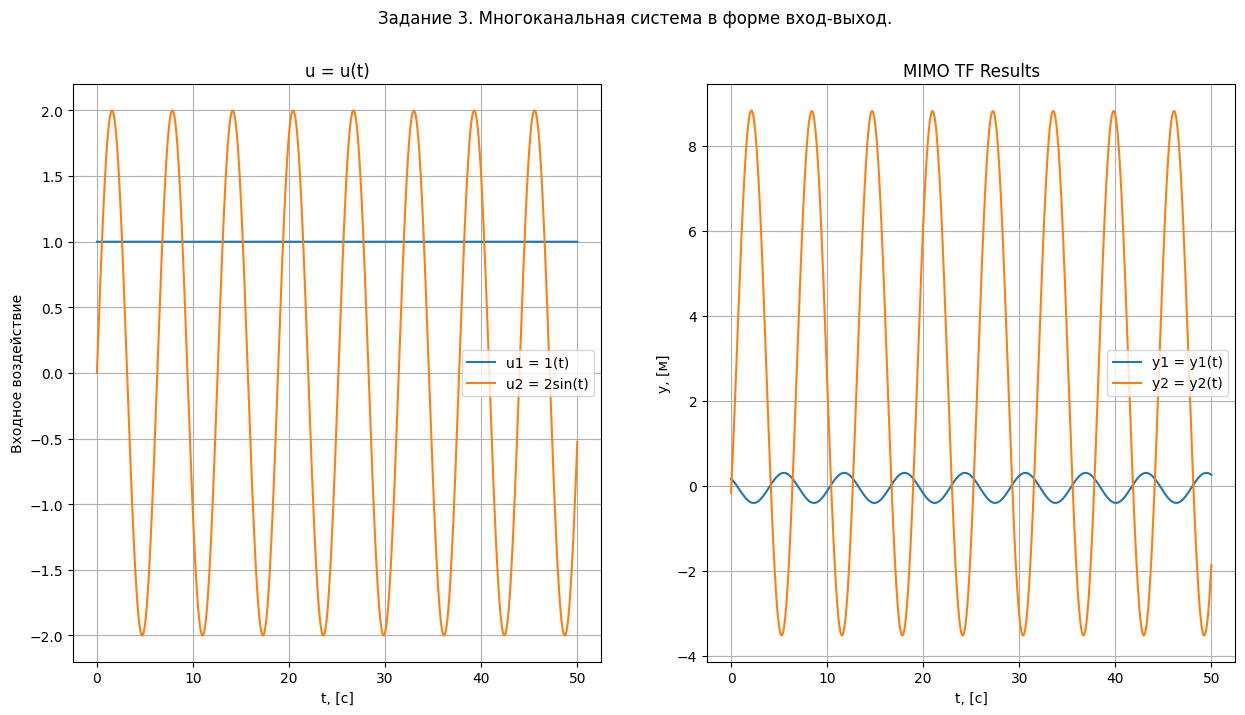

In [11]:
# Построение графиков
fig, axs = plt.subplots(1, 2, figsize=(15, 7.5))
fig.suptitle("Задание 3. Многоканальная система в форме вход-выход.")

axs[0].plot(ts, u1, label='u1 = 1(t)')
axs[0].plot(ts, u2, label='u2 = 2sin(t)')
axs[0].set_title(f"u = u(t)")
axs[0].set_xlabel(f"t, [c]")
axs[0].set_ylabel(f"Входное воздействие")
axs[0].grid(True)
axs[0].legend()

axs[1].plot(ts, mimo_TF_y[0], label='y1 = y1(t)')
axs[1].plot(ts, mimo_TF_y[1], label='y2 = y2(t)')
axs[1].set_title(f"MIMO TF Results")
axs[1].set_xlabel(f"t, [c]")
axs[1].set_ylabel(f"y, [м]")
axs[1].grid(True)
axs[1].legend()

plt.savefig(f'{SAVE_PATH}/task3.jpg')

### Задание 4. Одноканальная система в форме вход-состояние-выход.

In [12]:
# Создание системы из матриц В-С-В
siso_SS = control.ss(task4_A, task4_B, task4_C, [0])

# Симуляция
small_ts = ts[:5000]
siso_SS_y = control.forced_response(siso_SS, U=1, X0=[0, 0], T=small_ts).outputs

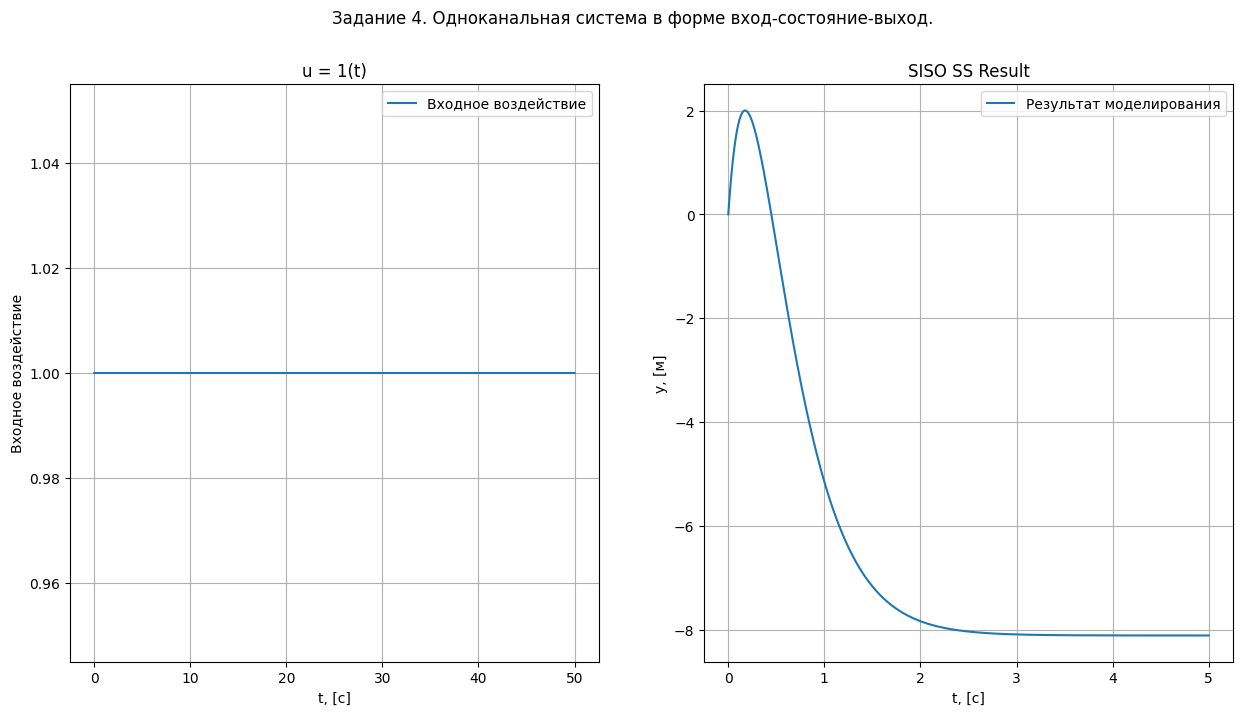

In [13]:
# Построение графиков
fig, axs = plt.subplots(1, 2, figsize=(15, 7.5))
fig.suptitle("Задание 4. Одноканальная система в форме вход-состояние-выход.")

axs[0].plot(ts, [1] * len(ts), label='Входное воздействие')
axs[0].set_title(f"u = 1(t)")
axs[0].set_xlabel(f"t, [c]")
axs[0].set_ylabel(f"Входное воздействие")
axs[0].grid(True)
axs[0].legend()
axs[1].plot(small_ts, siso_SS_y, label="Результат моделирования")
axs[1].set_title(f"SISO SS Result")
axs[1].set_xlabel(f"t, [c]")
axs[1].set_ylabel(f"y, [м]")
axs[1].grid(True)
axs[1].legend()

plt.savefig(f'{SAVE_PATH}/task4.jpg')

### Задание 5. Многоканальная система в форме вход-состояние-выход.

In [14]:
# Создание системы из матриц В-С-В
mimo_SS = control.ss(task5_A, task5_B, task5_C, 0)

# Симуляция
mimo_SS_y = control.forced_response(mimo_SS, U=mimo_Us, X0=[0, 0], T=ts).outputs

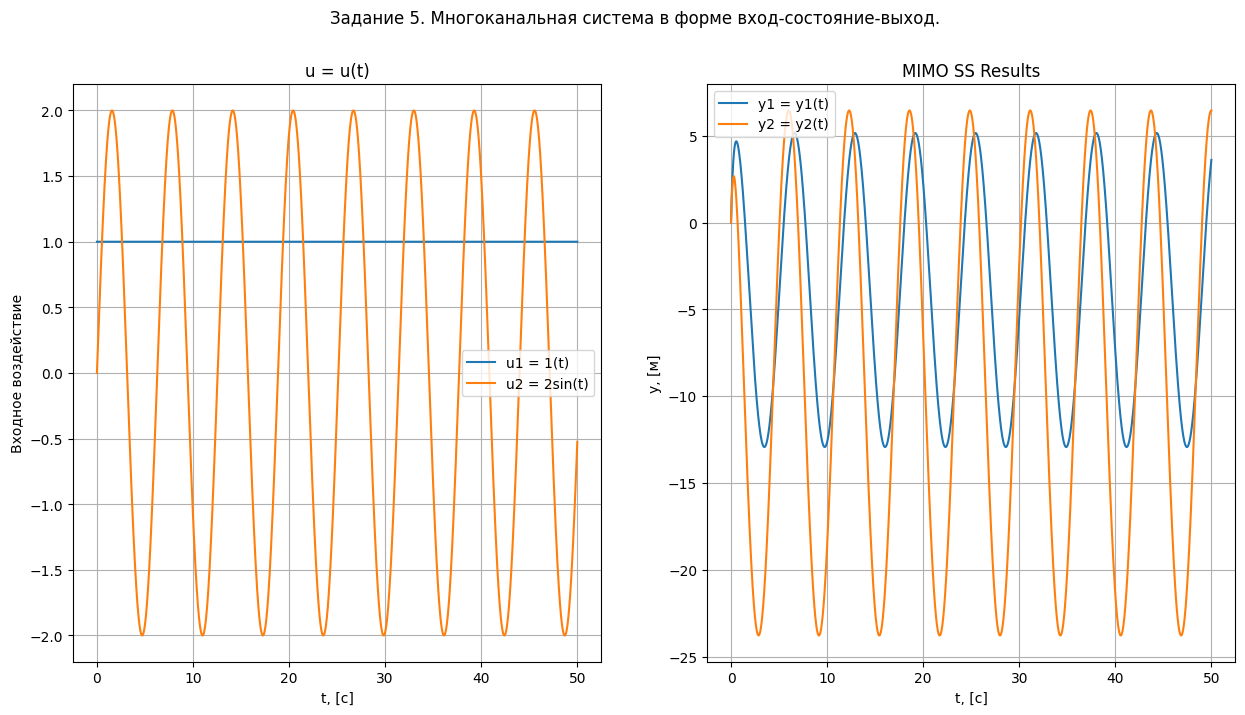

In [15]:
# Построение графиков
fig, axs = plt.subplots(1, 2, figsize=(15, 7.5))
fig.suptitle("Задание 5. Многоканальная система в форме вход-состояние-выход.")

axs[0].plot(ts, u1, label='u1 = 1(t)')
axs[0].plot(ts, u2, label='u2 = 2sin(t)')
axs[0].set_title(f"u = u(t)")
axs[0].set_xlabel(f"t, [c]")
axs[0].set_ylabel(f"Входное воздействие")
axs[0].grid(True)
axs[0].legend()

axs[1].plot(ts, mimo_SS_y[0], label='y1 = y1(t)')
axs[1].plot(ts, mimo_SS_y[1], label='y2 = y2(t)')
axs[1].set_title(f"MIMO SS Results")
axs[1].set_xlabel(f"t, [c]")
axs[1].set_ylabel(f"y, [м]")
axs[1].grid(True)
axs[1].legend()

plt.savefig(f'{SAVE_PATH}/task5.jpg')

# Выводы
В процессе работы была проведена симуляция в среде Python при помощи Python Control Systems Library для одноканальных и многоканальных систем, данных в двух основных представлениях: Вход-Выход и Вход-Состояние-Выход. Проведено моделирование систем с использованием вход- ных воздействий u(t) = 1 и u(t) = 2sint, а также моделирование свободного движения системы с 0 начальными условиями.

#### В результате моделирования было выявлено:
1. если воздействовать на систему постоянным значением входного синала, в нашем случае 1 или 0, то система переходит в состояние, при котором выход системы не изменяется, равен константе.
2. если воздействовать на систему переменным значением входного синала, в нашем случае 2 sin t, то выход системы принимает синусоидальную форму.
3. если воздействовать на систему одновременно постоянным и переменным значением входного синала, 1 и 2 sin t, то выход системы принимает смещенную синусоидальную форму.
